# Build an AI Agent From Scratch

Based on [**this tutorial**](https://learn.deeplearning.ai/courses/ai-agents-in-langgraph/lesson/2/build-an-agent-from-scratch)

# Setup

In [1]:
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

# Imports

In [3]:
import re

from openai import OpenAI

# Instanciate OpenAI Client

In [4]:
client = OpenAI()

# Sample prompt to illustrate
chat_completion = client.chat.completions.create(
    model = "gpt-3.5-turbo",
    messages = [{"role": "user", "content": "Hello world!"}]
)
chat_completion.choices[0].message.content

'Hello! How can I assist you today?'

# Defining Agent as a Class

The agents "behavio" is based on the "ReAct" framework, standing for: *Reasoning* then *Acting*.

Within this framework,
- first, an LLM ***thinks*** about what to do,
- then, it *decides* about an **action** to take.
- That action is then executed in an environment.
- Finally, an **observation** is returned.
- With that observation, the LLM then **repeats**, and continues until it *decides* that it's done.


Here's a schema illustrating how it works.

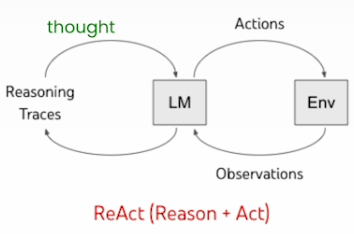

For further information, here's a [**link for the related research paper**](https://openreview.net/pdf?id=WE_vluYUL-X).

In [10]:
class Agent:
    def __init__(self, system=""):
        """Initialize the Agent with a system message"""
        self.system = system
        self.messages = []
        if self.system:
            self.messages.append({"role": "system", "content": system})
    
    def __call__(self, message):
        """
        - Add the message to the messages,
        - Generate the LLM completion's content,
        - Append this completion to the messages
        - Finally, return the content of the LLM's completion
        """
        self.messages.append({"role": "user", "content": message})
        result = self.execute()
        self.messages.append({"role": "assistant", "content": result})
        return result
    
    def execute(self):
        """Essentially return the LLM completion's content"""
        completion = client.chat.completions.create(
            model = "gpt-4o",
            temperature = 0,
            messages = self.messages
        )
        return completion.choices[0].message.content


Here's a generic prompt for implementing **ReAct**.

In [11]:
prompt = """
You run in a loop of Thought, Action, PAUSE, Observation.
At the end of the loop you output an Answer.
Use Thought to describe your thoughts about the question you have been asked.
Use Action to run one of the actions available to you - then return PAUSE.
Observation will be the result of running those actions.

Your available actions are:

calculate:
e.g. calculate: 4 * 7 / 3
Runs a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary

average_dog_weight:
e.g. average_dog_weight: Collie
returns average weight of a dog when given the breed

Example session:

Question: How much does a Bulldog weigh?
Thought: I should look the dogs weight using average_dog_weight
Action: average_dog_weight: Bulldog
PAUSE

You will be called again with this:

Observation: A Bulldog weights 51 lbs

You then output:

Answer: A bulldog weights 51 lbs
""".strip()

Here are some "toy" tools to illustrate.

In [12]:
def calculate(what):
    return eval(what)

def average_dog_weight(name):
    if name in "Scottish Terrier": 
        return("Scottish Terriers average 20 lbs")
    elif name in "Border Collie":
        return("a Border Collies average weight is 37 lbs")
    elif name in "Toy Poodle":
        return("a toy poodles average weight is 7 lbs")
    else:
        return("An average dog weights 50 lbs")

known_actions = {
    "calculate": calculate,
    "average_dog_weight": average_dog_weight
}

In [13]:
abot = Agent(prompt)

In [14]:
result = abot("How much a toy poodle weigh?")
print(result)

Thought: I should look up the average weight of a Toy Poodle using the available action.
Action: average_dog_weight: Toy Poodle
PAUSE


In [15]:
result = average_dog_weight("Toy Poodle")

In [16]:
result

'a toy poodles average weight is 7 lbs'

In [17]:
next_prompt = "Observation: {}".format(result)

In [18]:
abot(next_prompt)

'Answer: A Toy Poodle weighs an average of 7 lbs.'

In [19]:
abot.messages

[{'role': 'system',
  'content': 'You run in a loop of Thought, Action, PAUSE, Observation.\nAt the end of the loop you output an Answer.\nUse Thought to describe your thoughts about the question you have been asked.\nUse Action to run one of the actions available to you - then return PAUSE.\nObservation will be the result of running those actions.\n\nYour available actions are:\n\ncalculate:\ne.g. calculate: 4 * 7 / 3\nRuns a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary\n\naverage_dog_weight:\ne.g. average_dog_weight: Collie\nreturns average weight of a dog when given the breed\n\nExample session:\n\nQuestion: How much does a Bulldog weigh?\nThought: I should look the dogs weight using average_dog_weight\nAction: average_dog_weight: Bulldog\nPAUSE\n\nYou will be called again with this:\n\nObservation: A Bulldog weights 51 lbs\n\nYou then output:\n\nAnswer: A bulldog weights 51 lbs'},
 {'role': 'user', 'content': 'How much a toy 

In [29]:
# Initializing for a new task
abot = Agent(prompt)

In [30]:
abot.messages

[{'role': 'system',
  'content': 'You run in a loop of Thought, Action, PAUSE, Observation.\nAt the end of the loop you output an Answer.\nUse Thought to describe your thoughts about the question you have been asked.\nUse Action to run one of the actions available to you - then return PAUSE.\nObservation will be the result of running those actions.\n\nYour available actions are:\n\ncalculate:\ne.g. calculate: 4 * 7 / 3\nRuns a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary\n\naverage_dog_weight:\ne.g. average_dog_weight: Collie\nreturns average weight of a dog when given the breed\n\nExample session:\n\nQuestion: How much does a Bulldog weigh?\nThought: I should look the dogs weight using average_dog_weight\nAction: average_dog_weight: Bulldog\nPAUSE\n\nYou will be called again with this:\n\nObservation: A Bulldog weights 51 lbs\n\nYou then output:\n\nAnswer: A bulldog weights 51 lbs'}]

In [31]:
question = """I have 2 dogs, a border collie and a scottish terrier. \
What is their combined weight"""
print(abot(question))

Thought: I need to find the average weight of both a Border Collie and a Scottish Terrier, then add them together to get the combined weight.
Action: average_dog_weight: Border Collie
PAUSE


In [32]:
next_prompt = "Observation: {}".format(average_dog_weight("Border Collie"))
print(next_prompt)

Observation: a Border Collies average weight is 37 lbs


In [33]:
print(abot(next_prompt))

Thought: Now I need to find the average weight of a Scottish Terrier.
Action: average_dog_weight: Scottish Terrier
PAUSE


In [34]:
next_prompt = "Observation: {}".format(average_dog_weight("Scottish Terrier"))
print(next_prompt)

Observation: Scottish Terriers average 20 lbs


In [35]:
print(abot(next_prompt))

Thought: I now have the average weights of both dogs. I will add them together to find their combined weight.
Action: calculate: 37 + 20
PAUSE


In [36]:
next_prompt = "Observation: {}".format(eval("37 + 20"))
print(next_prompt)

Observation: 57


In [37]:
print(abot(next_prompt))

Answer: The combined weight of a Border Collie and a Scottish Terrier is 57 lbs.


# Incorporate This in a Loop

In [38]:
# Set a regex to find the action
action_re = re.compile('^Action: (\w+): (.*)$')

In [42]:
def query(question, max_turns=5):
    count = 0
    bot = Agent(prompt)
    next_prompt = question
    while count < 5:
        count += 1
        result = bot(next_prompt)
        print(result)
        actions = [
            action_re.match(a)
            for a in result.split("\n")
            if action_re.match(a)
        ]
        if actions:
            # There is an action to run
            action, action_input = actions[0].groups()
            if action not in known_actions:
                raise Exception("Unknown actions: {}: {}".format(action, action_input))
            print(" -- running {} {}".format(action, action_input))
            observation = known_actions[action](action_input)
            next_prompt = "Observation: {}".format(observation)
            print(next_prompt)
        else:
            # There are no more actions to perform
            return

In [43]:
question = """I have 2 dogs, a border collie and a scottish terrier. \
What is their combined weight"""
query(question)

Thought: I need to find the average weight of both a Border Collie and a Scottish Terrier, then sum these weights to get the combined weight.
Action: average_dog_weight: Border Collie
PAUSE
 -- running average_dog_weight Border Collie
Observation: a Border Collies average weight is 37 lbs
Thought: Now I need to find the average weight of a Scottish Terrier.
Action: average_dog_weight: Scottish Terrier
PAUSE
 -- running average_dog_weight Scottish Terrier
Observation: Scottish Terriers average 20 lbs
Thought: I now have the average weights of both dogs. I need to sum these weights to get the combined weight.
Action: calculate: 37 + 20
PAUSE
 -- running calculate 37 + 20
Observation: 57
Answer: The combined weight of a Border Collie and a Scottish Terrier is 57 lbs.
